In [110]:
import scipy
import numpy as np
import pandas as pd
from natsort import natsorted 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 14})
from scipy.stats import spearmanr
import pickle
import seaborn as sns
from scipy.stats import ttest_ind
import itertools
from data_utils import reorganize_rois, reorder_hemispheres, load_aperiodic_from_mat_files

In [94]:
# Load the dictionary with fooof exponent data from file
with open("G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\Foof_res_correct\\Fooof_exponents.pkl", 'rb') as file:
    fooof_exponent_dict = pickle.load(file)

In [95]:
### LOADING ROIs LABELS FROM EEGLAB DESIKAN ATLAS ###
labels = pd.read_excel('G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\Foof_res\\Desikan_regions.xlsx').values.tolist()
labels = [parcel_name[0].replace("'", "") for parcel_name in labels]
print(f'ROIs names: {labels}')

ROIs names: ['bankssts L', 'bankssts R', 'caudalanteriorcingulate L', 'caudalanteriorcingulate R', 'caudalmiddlefrontal L', 'caudalmiddlefrontal R', 'cuneus L', 'cuneus R', 'entorhinal L', 'entorhinal R', 'frontalpole L', 'frontalpole R', 'fusiform L', 'fusiform R', 'inferiorparietal L', 'inferiorparietal R', 'inferiortemporal L', 'inferiortemporal R', 'insula L', 'insula R', 'isthmuscingulate L', 'isthmuscingulate R', 'lateraloccipital L', 'lateraloccipital R', 'lateralorbitofrontal L', 'lateralorbitofrontal R', 'lingual L', 'lingual R', 'medialorbitofrontal L', 'medialorbitofrontal R', 'middletemporal L', 'middletemporal R', 'paracentral L', 'paracentral R', 'parahippocampal L', 'parahippocampal R', 'parsopercularis L', 'parsopercularis R', 'parsorbitalis L', 'parsorbitalis R', 'parstriangularis L', 'parstriangularis R', 'pericalcarine L', 'pericalcarine R', 'postcentral L', 'postcentral R', 'posteriorcingulate L', 'posteriorcingulate R', 'precentral L', 'precentral R', 'precuneus L'

### GRANGER CAUSALITY DEGREE ####

In [96]:
path = "G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\GC_res\\Corr_Fooof_degree_res\\"
inward_deg_theta = scipy.io.loadmat(path + "inward_deg_theta.mat")['inward_deg_theta']
inward_deg_delta = scipy.io.loadmat(path + "inward_deg_delta.mat")['inward_deg_delta']
outward_deg_theta = scipy.io.loadmat(path + "outward_deg_theta.mat")['outward_deg_theta']
outward_deg_delta = scipy.io.loadmat(path + "outward_deg_delta.mat")['outward_deg_delta']

fooof_matrix = scipy.io.loadmat("g:\Drive condivisi\AnalisiSegnaliEeg\HD EEG\Crisi_HDEEG\GC_res\FoooF_matrix.mat")['outputMatrix']

In [97]:
### LOADING EXCEL FILE WITH THE INDICES OD RELEVANT ROIs x SUBJECT ###
file_path = "G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\relevant_rois_indices.xlsx" 
df_relevant_rois = pd.read_excel(file_path)
# Extract indices and IDs
list_indices =  list(zip(df_relevant_rois["ID"].tolist(), list(df_relevant_rois["INDICES_strict"].tolist())))

list_indices_GM = list_indices.copy()

for index in [27,10]:
    del list_indices_GM[index]

indices_GM = []
for idx, (_, num_str) in enumerate(list_indices_GM):
    nums = [int(x.strip()) for x in num_str.split(',')]
    indices_GM.append(nums)

In [98]:
def select_data(matrix, selected_indices, col_idx):
    """
    Select rows in 'selected_indices' for column 'col_idx' from 'matrix',
    and also select all rows *not* in 'selected_indices' for the same column.
    
    Returns:
        selected_rows, not_selected_rows
    """
    mask = ~np.isin(np.arange(matrix.shape[0]), selected_indices)
    selected_rows = matrix[selected_indices, col_idx, :]
    not_selected_rows = matrix[mask, col_idx, :]
    return selected_rows, not_selected_rows

# Initialize lists to store results
selected_fooof_list, not_selected_fooof_list = [], []
selected_degree_inward_theta, not_selected_degree_inward_theta = [], []
selected_degree_outward_theta, not_selected_degree_outward_theta = [], []
selected_degree_inward_delta, not_selected_degree_inward_delta = [], []
selected_degree_outward_delta, not_selected_degree_outward_delta = [], []

for idx, selected_indices in enumerate(indices_GM):
    fooof_sel, fooof_not_sel = select_data(fooof_matrix, selected_indices, idx)
    inward_theta_sel, inward_theta_not_sel = select_data(inward_deg_theta, selected_indices, idx)
    inward_delta_sel, inward_delta_not_sel = select_data(inward_deg_delta, selected_indices, idx)
    outward_theta_sel, outward_theta_not_sel = select_data(outward_deg_theta, selected_indices, idx)
    outward_delta_sel, outward_delta_not_sel = select_data(outward_deg_delta, selected_indices, idx)

    selected_fooof_list.append(fooof_sel)
    not_selected_fooof_list.append(fooof_not_sel)

    selected_degree_inward_theta.append(inward_theta_sel)
    not_selected_degree_inward_theta.append(inward_theta_not_sel)

    selected_degree_outward_theta.append(outward_theta_sel)
    not_selected_degree_outward_theta.append(outward_theta_not_sel)

    selected_degree_inward_delta.append(inward_delta_sel)
    not_selected_degree_inward_delta.append(inward_delta_not_sel)

    selected_degree_outward_delta.append(outward_delta_sel)
    not_selected_degree_outward_delta.append(outward_delta_not_sel)

In [99]:
# Helper to compute mean, std, and standard error
def compute_avg_std_se(nested_list):
    flat = [nested_list[i][j] for i in range(len(nested_list)) for j in range(len(nested_list[i]))]
    data = np.stack(flat)
    avg = np.mean(data, axis=0)
    std = np.std(data, axis=0, ddof=1)
    se = std / np.sqrt(data.shape[0])
    return avg, std, se


In [100]:
selected_fooof = np.mean([selected_fooof_list[i][j] for i in range(len(selected_fooof_list)) for j in range(len(selected_fooof_list[i]))], axis = 0)
not_selected_fooof = np.mean([not_selected_fooof_list[i][j] for i in range(len(not_selected_fooof_list)) for j in range(len(not_selected_fooof_list[i]))], axis = 0)

##### OUTWARD DEGREE THETA

In [101]:
def plot_degree_over_time(selected_data, not_selected_data, compute_avg_std_se_fn, 
                          sampling_rate=256, signal_duration_sec=13*60, 
                          window_length_sec=60, step_fraction=0.1, 
                          num_segments=121):
    """
    Plots the average degree over time for selected and non-selected regions,
    including standard error shading.
    
    Parameters:
    - selected_data: np.ndarray, degree values for selected regions
    - not_selected_data: np.ndarray, degree values for non-selected regions
    - compute_avg_std_se_fn: function that returns avg, std, and se
    - sampling_rate: int, sampling rate in Hz
    - signal_duration_sec: int, total duration in seconds
    - window_length_sec: int, analysis window length in seconds
    - step_fraction: float, fraction of window used as step (e.g. 0.1 for 90% overlap)
    - num_segments: int, number of sliding windows
    """
    
    # Compute means and standard errors
    avg_sel, _, se_sel = compute_avg_std_se_fn(selected_data)
    avg_nonsel, _, se_nonsel = compute_avg_std_se_fn(not_selected_data)

    # Time vector for window centers (in minutes)
    step_size_sec = window_length_sec * step_fraction
    window_start_times = np.arange(0, step_size_sec * num_segments, step_size_sec)
    window_center_times = window_start_times + (window_length_sec / 2)
    window_center_times_min = (window_center_times / 60)[:120]

    # Plotting
    plt.figure(figsize=(12, 6))
    x = window_center_times_min
    plt.plot(x, avg_sel, label='Epileptogenic Regions', color='blue')
    plt.plot(x, avg_nonsel, label='Non-Epileptogenic Regions', color='red')

    plt.fill_between(x, avg_sel - se_sel, avg_sel + se_sel, color='blue', alpha=0.2)
    plt.fill_between(x, avg_nonsel - se_nonsel, avg_nonsel + se_nonsel, color='red', alpha=0.2)

    plt.xlabel('Time (minutes)')
    plt.ylabel('Degree')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

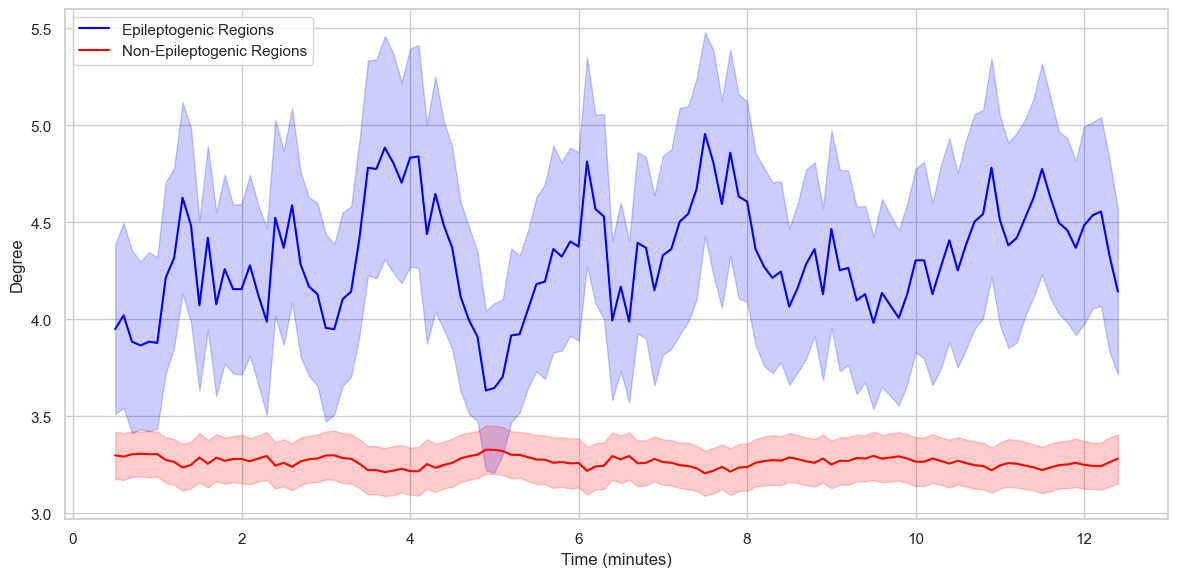

In [102]:
plot_degree_over_time(selected_degree_outward_theta, not_selected_degree_outward_theta, compute_avg_std_se, 
                          sampling_rate=256, signal_duration_sec=13*60, 
                          window_length_sec=60, step_fraction=0.1, 
                          num_segments=121)

##### INWARD DEGREE THETA

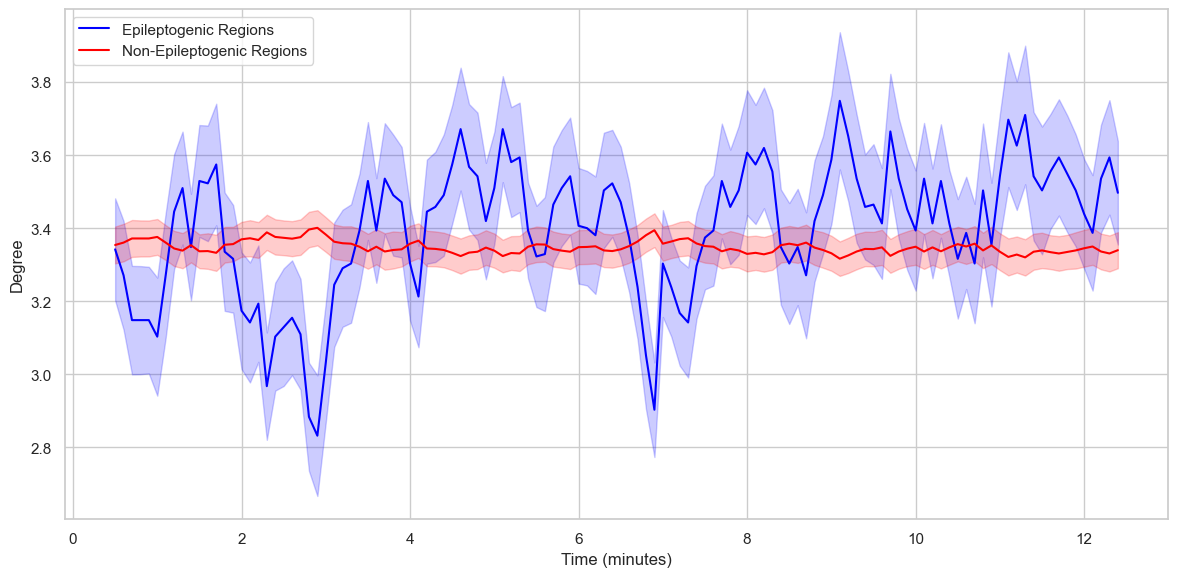

In [103]:
plot_degree_over_time(selected_degree_inward_theta, not_selected_degree_inward_theta, compute_avg_std_se, 
                          sampling_rate=256, signal_duration_sec=13*60, 
                          window_length_sec=60, step_fraction=0.1, 
                          num_segments=121)

##### OUTWARD DEGREE DELTA

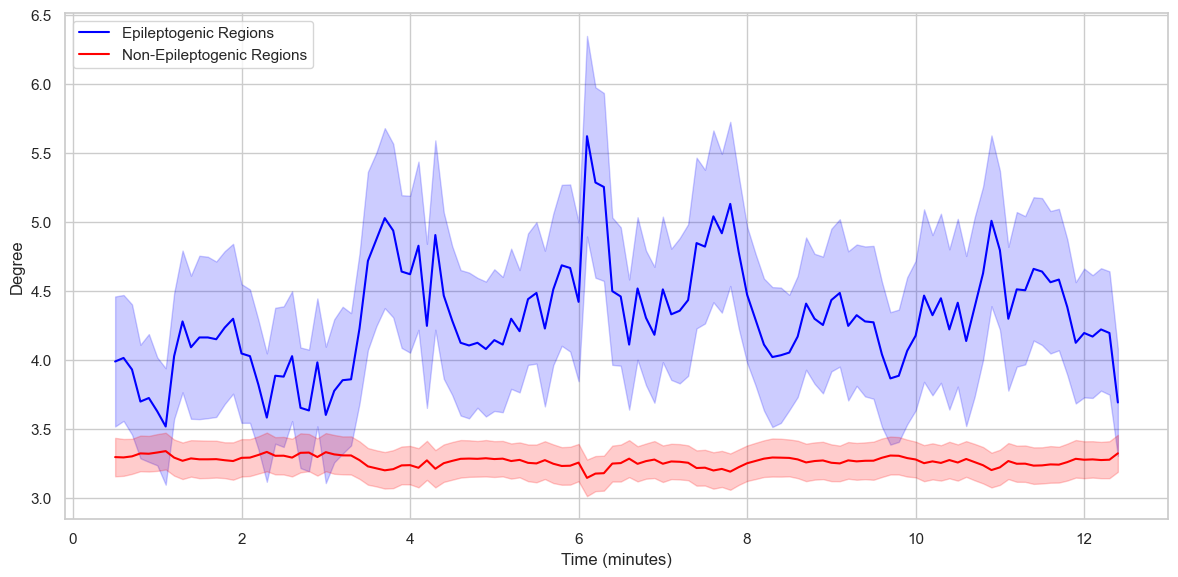

In [104]:
plot_degree_over_time(selected_degree_outward_delta, not_selected_degree_outward_delta, compute_avg_std_se, 
                          sampling_rate=256, signal_duration_sec=13*60, 
                          window_length_sec=60, step_fraction=0.1, 
                          num_segments=121)

##### INWARD DEGREE DELTA

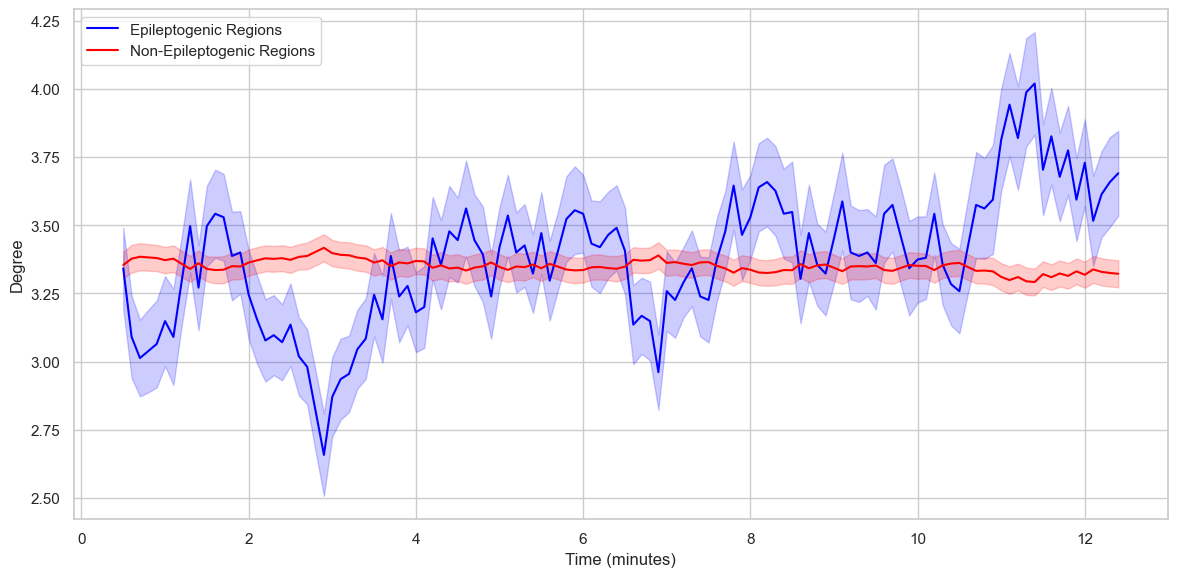

In [105]:
plot_degree_over_time(selected_degree_inward_delta, not_selected_degree_inward_delta, compute_avg_std_se, 
                          sampling_rate=256, signal_duration_sec=13*60, 
                          window_length_sec=60, step_fraction=0.1, 
                          num_segments=121)

### BOXPLOT DEGREE AND CORRELATIONS INTERICTAL STATE AND PREICTAL DELTA BAND

#### AVERAGE BOXPLOT DELTA

In [107]:
# Define the path to the .mat file containing preprocessed data
path = "G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\Per_Immagini_paper\\"

# Load the MATLAB .mat file containing average per subject Granger Causality (GC) measures
interictal_state_boxplot_data = scipy.io.loadmat(path + "GC_resting_per_boxplot_avg_per_sj.mat")['GC_res_Epi_nEPI_avg_per_sj']

# Extract string keys from the first row of the data
# Each key is expected to be stored as a nested array -> string format
keys = [interictal_state_boxplot_data[0][i][0] for i in range(len(interictal_state_boxplot_data[0]))]

# Optionally replace with more readable keys
new_keys = ["Interic Epi Inward", "Interic Non-Epi Inward", 
            "Interic Epi Outward", "Interic Non-Epi Outward"]

# Extract corresponding numerical values from the second row nd flatten them
values = [interictal_state_boxplot_data[1][i].flatten() 
          for i in range(len(interictal_state_boxplot_data[0]))][0:4]

# Create a dictionary mapping readable labels to the extracted values
ic_boxplot_dict = dict(zip(new_keys, values))

# Convert each array into a pandas Series, useful for boxplotting and statistical analysis
data_series = {key: pd.Series(value) for key, value in ic_boxplot_dict.items()}

# Combine all Series into a single DataFrame for plotting
interictal_state_boxplot_data_df = pd.DataFrame(data_series)

# Clean up temporary variables to avoid namespace clutter
del ic_boxplot_dict
del data_series

In [106]:
# Each `subj` is assumed to be a 2D array: (time_windows × ROIs)
# Averaging over axis=(0,1) gives a single scalar per subject
epi_preictal_inward_delta = [np.mean(subj, axis= (0,1)) for subj in selected_degree_inward_delta]
nonepi_preictal_inward_delta = [np.mean(subj, axis= (0,1)) for subj in not_selected_degree_inward_delta]
epi_preictal_outward_delta = [np.mean(subj, axis= (0,1)) for subj in selected_degree_outward_delta]
nonepi_preictal_outward_delta = [np.mean(subj, axis= (0,1)) for subj in not_selected_degree_outward_delta]

In [108]:
# Define readable keys for the pre-ictal data categories
# These represent the direction (Inward/Outward) and ROIs type (Epi/Non-Epi)
preict_keys = [
    "Pre-ictal Epi Inward", 
    "Pre-ictal Non-Epi Inward", 
    "Pre-ictal Epi Outward", 
    "Pre-ictal Non-Epi Outward"
]

# Corresponding values: lists of averages previously defined
preict_values = [
    epi_preictal_inward_delta, 
    nonepi_preictal_inward_delta, 
    epi_preictal_outward_delta, 
    nonepi_preictal_outward_delta
]

# Create a dictionary mapping labels to their data
preictal_boxplot_dict = dict(zip(preict_keys, preict_values))

# Convert each list of subject values into a pandas Series for compatibility with DataFrame
data_series = {
    key: pd.Series(value) 
    for key, value in preictal_boxplot_dict.items()
}

# Combine all Series into a single DataFrame for visualization or statistical analysis
# Each column represents a group, each row is a subject-level value
preictal_boxplot_data_df = pd.DataFrame(data_series)

# Clean up intermediate variables to avoid cluttering the namespace
del preictal_boxplot_dict
del data_series

In [ ]:
# concatenating the interictal and preictal dataframes for boxplot
boxplot_final_df = pd.concat([interictal_state_boxplot_data_df, preictal_boxplot_data_df], axis=1)

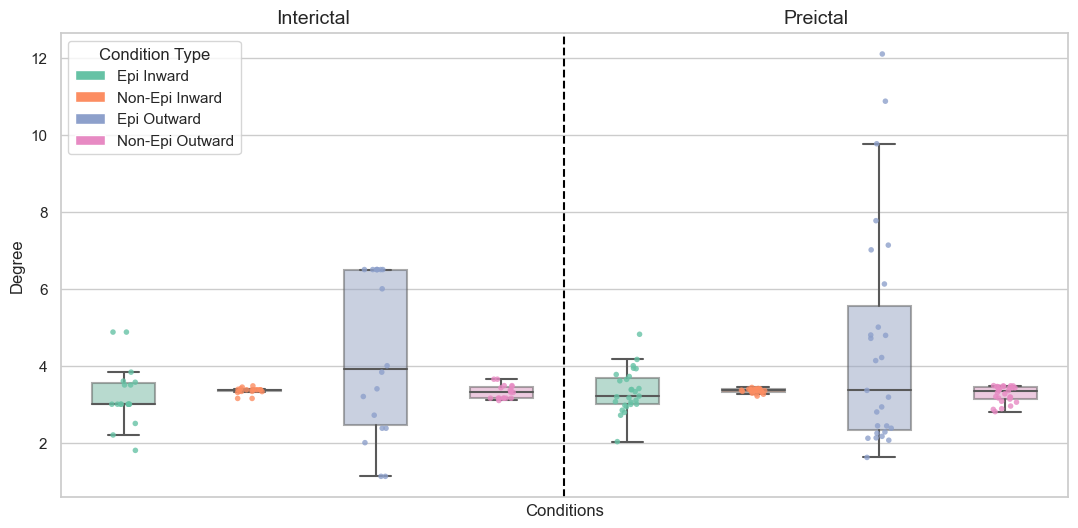

In [109]:
# Prepare long-form DataFrame
df_long = boxplot_final_df.melt(var_name='Condition', value_name='Degree')

# Set your desired order
condition_order = [
    'Interic Epi Inward', 'Interic Non-Epi Inward', 'Interic Epi Outward', 'Interic Non-Epi Outward',
    'Pre-ictal Epi Inward', 'Pre-ictal Non-Epi Inward', 'Pre-ictal Epi Outward', 'Pre-ictal Non-Epi Outward'
]

# Make sure the order is respected
df_long['Condition'] = pd.Categorical(df_long['Condition'], categories=condition_order, ordered=True)

# Color setup
base_colors = sns.color_palette("Set2", n_colors=4)
condition_types = ['Epi Inward', 'Non-Epi Inward', 'Epi Outward', 'Non-Epi Outward']
color_map = dict(zip(condition_types, base_colors))

# Map each condition to a color
def assign_color(cond):
    if "Inward" in cond:
        if "Epi" in cond and "Non" not in cond:
            return color_map['Epi Inward']
        elif "Non-Epi" in cond:
            return color_map['Non-Epi Inward']
    elif "Outward" in cond:
        if "Epi" in cond and "Non" not in cond:
            return color_map['Epi Outward']
        elif "Non-Epi" in cond:
            return color_map['Non-Epi Outward']
    return 'gray'

colors = [assign_color(c) for c in condition_order]

# Create figure
plt.figure(figsize=(11, 5.5))

# Draw boxplot with color per condition
sns.boxplot(data=df_long, x='Condition', y='Degree', palette=colors, width=0.5, boxprops=dict(alpha=0.5), showcaps=True, whiskerprops={'linewidth': 1.5}, fliersize=0)
# Overlay stripplot
sns.stripplot(data=df_long, x='Condition', y='Degree', palette=colors, jitter=True, size=4, alpha=0.8)
# Add vertical line between interictal and Pre-Ictal
plt.axvline(3.5, color='black', linestyle='--')

# Add custom section labels
plt.text(1.5, plt.ylim()[1] + 0.02 * plt.ylim()[1], 'Interictal', ha='center')
plt.text(5.5, plt.ylim()[1] + 0.02 * plt.ylim()[1], 'Preictal', ha='center')
plt.xticks([],[])
# Custom legend
legend_elements = [Patch(facecolor=col, label=lbl) for col, lbl in zip(base_colors, condition_types)]
plt.legend(handles=legend_elements, title='Condition Type', loc='upper left', frameon=True)

plt.xlabel("Conditions")
plt.ylabel("Degree")
plt.tight_layout()
plt.show()

In [111]:
results = []

# Generate all unique column pairs
column_pairs = list(itertools.combinations(boxplot_final_df.columns, 2))

# Perform t-tests
for col1, col2 in column_pairs:
    data1 = boxplot_final_df[col1].dropna()
    data2 = boxplot_final_df[col2].dropna()
    t_stat, p_val = ttest_ind(data1, data2, equal_var=False)  # Welch’s t-test
    results.append({
        'Column 1': col1,
        'Column 2': col2,
        't-statistic': t_stat,
        'p-value': p_val
    })

# Convert to a DataFrame for easier viewing
t_test_results = pd.DataFrame(results)
significant_results = t_test_results[t_test_results['p-value'] < 0.05].reset_index(drop=True)

print(significant_results)

                   Column 1                   Column 2  t-statistic   p-value
0        Interic Epi Inward      Pre-ictal Epi Outward    -2.231755  0.032902
1    Interic Non-Epi Inward      Pre-ictal Epi Outward    -2.146448  0.041317
2       Interic Epi Outward  Pre-ictal Non-Epi Outward     2.116989  0.049098
3   Interic Non-Epi Outward      Pre-ictal Epi Outward    -2.201176  0.036695
4      Pre-ictal Epi Inward      Pre-ictal Epi Outward    -2.126704  0.042419
5  Pre-ictal Non-Epi Inward      Pre-ictal Epi Outward    -2.144525  0.041503
6     Pre-ictal Epi Outward  Pre-ictal Non-Epi Outward     2.290675  0.030244


#### AVERAGE BOXPLOT THETA

In [118]:
# Define the path to the .mat file containing preprocessed data
path = "G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\Per_Immagini_paper\\"
# Load the MATLAB .mat file containing average per subject Granger Causality (GC) measures
interictal_state_boxplot_data = scipy.io.loadmat(path + "GC_resting_per_boxplot_avg_per_sj.mat")['GC_res_Epi_nEPI_avg_per_sj']
# Extract string keys from the first row of the data
# Each key is expected to be stored as a nested array -> string format
keys = [interictal_state_boxplot_data[0][i][0] for i in range(len(interictal_state_boxplot_data[0]))]
# Optionally replace with more readable keys
new_keys = ["Interic Epi Inward THETA", "Interic Non-Epi Inward THETA", "Interic Epi Outward THETA", "Interic Non-Epi Outward THETA"]
# Extract corresponding numerical values from the second row nd flatten them
values = [interictal_state_boxplot_data[1][i].flatten() for i in range(len(interictal_state_boxplot_data[0]))][4:]
# Create a dictionary mapping readable labels to the extracted values
ic_boxplot_dict = dict(zip(new_keys, values))
# Convert each array into a pandas Series, useful for boxplotting and statistical analysis
data_series = {key: pd.Series(value) for key, value in ic_boxplot_dict.items()}
# Combine all Series into a single DataFrame for plotting
interictal_state_boxplot_data_df_theta = pd.DataFrame(data_series)
# Clean up temporary variables to avoid namespace clutter
del ic_boxplot_dict; del data_series

In [119]:
# Each `subj` is assumed to be a 2D array: (time_windows × ROIs)
# Averaging over axis=(0,1) gives a single scalar per subject
epi_preictal_inward_theta = [np.mean(subj, axis= (0,1)) for subj in selected_degree_inward_theta]
nonepi_preictal_inward_theta = [np.mean(subj, axis= (0,1)) for subj in not_selected_degree_inward_theta]
epi_preictal_outward_theta = [np.mean(subj, axis= (0,1)) for subj in selected_degree_outward_theta]
nonepi_preictal_outward_theta = [np.mean(subj, axis= (0,1)) for subj in not_selected_degree_outward_theta]

In [120]:
# Define readable keys for the pre-ictal data categories
# These represent the direction (Inward/Outward) and ROIs type (Epi/Non-Epi)
preict_keys = ["Pre-ictal Epi Inward THETA", "Pre-ictal Non-Epi Inward THETA", "Pre-ictal Epi Outward THETA", "Pre-ictal Non-Epi Outward THETA"]
# Corresponding values: lists of averages previously defined
preict_values = [epi_preictal_inward_theta, nonepi_preictal_inward_theta, epi_preictal_outward_theta, nonepi_preictal_outward_theta]
# Create a dictionary mapping labels to their data
preictal_boxplot_dict = dict(zip(preict_keys, preict_values))
# Convert each list of subject values into a pandas Series for compatibility with DataFrame
data_series = {key: pd.Series(value) for key, value in preictal_boxplot_dict.items()}
# Combine all Series into a single DataFrame for visualization or statistical analysis
# Each column represents a group, each row is a subject-level value
preictal_boxplot_data_df_theta = pd.DataFrame(data_series)
del preictal_boxplot_dict; del data_series

In [121]:
boxplot_final_df_theta = pd.concat([interictal_state_boxplot_data_df_theta, preictal_boxplot_data_df_theta], axis=1)

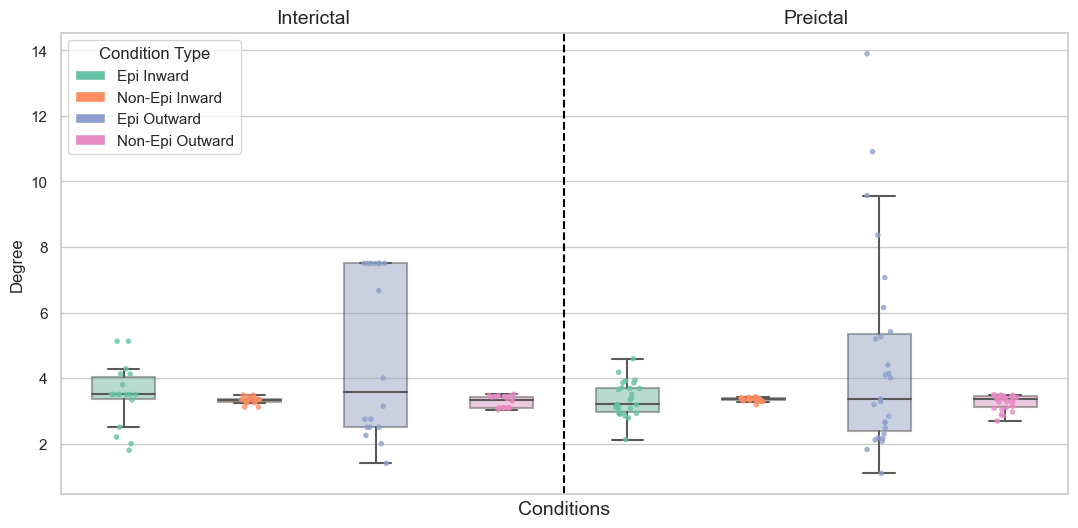

In [116]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Prepare long-form DataFrame
df_long = boxplot_final_df_theta.melt(var_name='Condition', value_name='Degree')

# Set your desired order
condition_order = [
    'Interic Epi Inward THETA', 'Interic Non-Epi Inward THETA', 'Interic Epi Outward THETA', 'Interic Non-Epi Outward THETA',
    'Pre-ictal Epi Inward THETA', 'Pre-ictal Non-Epi Inward THETA', 'Pre-ictal Epi Outward THETA', 'Pre-ictal Non-Epi Outward THETA'
]

# Make sure the order is respected
df_long['Condition'] = pd.Categorical(df_long['Condition'], categories=condition_order, ordered=True)

# Color setup
base_colors = sns.color_palette("Set2", n_colors=4)
condition_types = ['Epi Inward', 'Non-Epi Inward', 'Epi Outward', 'Non-Epi Outward']
color_map = dict(zip(condition_types, base_colors))

# Map each condition to a color
def assign_color(cond):
    if "Inward" in cond:
        if "Epi" in cond and "Non" not in cond:
            return color_map['Epi Inward']
        elif "Non-Epi" in cond:
            return color_map['Non-Epi Inward']
    elif "Outward" in cond:
        if "Epi" in cond and "Non" not in cond:
            return color_map['Epi Outward']
        elif "Non-Epi" in cond:
            return color_map['Non-Epi Outward']
    return 'gray'

colors = [assign_color(c) for c in condition_order]

# Create figure
plt.figure(figsize=(11, 5.5))

# Draw boxplot with color per condition
sns.boxplot(data=df_long, x='Condition', y='Degree', palette=colors, width=0.5, boxprops=dict(alpha=0.5), showcaps=True, whiskerprops={'linewidth': 1.5}, fliersize=0)

# Overlay stripplot
sns.stripplot(data=df_long, x='Condition', y='Degree', palette=colors, jitter=True, size=4, alpha=0.8)

# Add vertical line between RS and Pre-Ictal
plt.axvline(3.5, color='black', linestyle='--')

# Add custom section labels
plt.text(1.5, plt.ylim()[1] + 0.02 * plt.ylim()[1], 'Interictal', ha='center', fontsize=14)
plt.text(5.5, plt.ylim()[1] + 0.02 * plt.ylim()[1], 'Preictal', ha='center', fontsize=14)
plt.xticks([],[])
# Custom legend
legend_elements = [Patch(facecolor=col, label=lbl) for col, lbl in zip(base_colors, condition_types)]
plt.legend(handles=legend_elements, title='Condition Type', loc='upper left', frameon=True)

plt.xlabel("Conditions", fontsize=14)
plt.ylabel("Degree")
plt.tight_layout()
plt.show()

In [122]:
from scipy.stats import ttest_ind
import itertools

results = []

# Generate all unique column pairs
column_pairs = list(itertools.combinations(boxplot_final_df_theta.columns, 2))

# Perform t-tests
for col1, col2 in column_pairs:
    data1 = boxplot_final_df_theta[col1].dropna()
    data2 = boxplot_final_df_theta[col2].dropna()
    t_stat, p_val = ttest_ind(data1, data2, equal_var=False)  # Welch’s t-test
    results.append({
        'Column 1': col1,
        'Column 2': col2,
        't-statistic': t_stat,
        'p-value': p_val
    })

# Convert to a DataFrame for easier viewing
t_test_results = pd.DataFrame(results)
significant_results = t_test_results[t_test_results['p-value'] < 0.05].reset_index(drop=True)

print(significant_results)

                        Column 1                         Column 2  \
0   Interic Non-Epi Inward THETA        Interic Epi Outward THETA   
1   Interic Non-Epi Inward THETA      Pre-ictal Epi Outward THETA   
2      Interic Epi Outward THETA    Interic Non-Epi Outward THETA   
3      Interic Epi Outward THETA       Pre-ictal Epi Inward THETA   
4      Interic Epi Outward THETA   Pre-ictal Non-Epi Inward THETA   
5      Interic Epi Outward THETA  Pre-ictal Non-Epi Outward THETA   
6  Interic Non-Epi Outward THETA      Pre-ictal Epi Outward THETA   
7    Pre-ictal Epi Outward THETA  Pre-ictal Non-Epi Outward THETA   

   t-statistic   p-value  
0    -2.344843  0.031391  
1    -2.055491  0.049970  
2     2.422405  0.026752  
3     2.268403  0.035858  
4     2.309194  0.033754  
5     2.443667  0.025617  
6    -2.133819  0.042356  
7     2.155159  0.040486  


### PREICTAL STATE BARPLOT DATA

In [47]:
path = "G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\Per_Immagini_paper\\"
corr_degree_exp_resting = scipy.io.loadmat(path + "Correlation_granger_exp_rest.mat")['Corr_GC_exp_res']

columns = [col[0] for col in corr_degree_exp_resting[0]][1:]
rho = [r[0] for r in corr_degree_exp_resting[1]][1:]
pvals = [p[0] for p in corr_degree_exp_resting[2]][1:]

corr_degree_exp_resting_df = pd.DataFrame([rho, pvals], columns=columns)

In [48]:
avg_fooof_epi, avg_fooof_nonepi = [np.mean(subj, axis=(0,1)) for subj in selected_fooof_list], [np.mean(subj, axis=(0,1)) for subj in not_selected_fooof_list]

avg_epi_degree_inward_theta, avg_nonepi_degree_inward_theta = [np.mean(subj, axis=(0,1)) for subj in selected_degree_inward_theta], [np.mean(subj, axis=(0,1)) for subj in not_selected_degree_inward_theta]

avg_epi_degree_outward_theta, avg_nonepi_degree_outward_theta = [np.mean(subj, axis=(0,1)) for subj in selected_degree_outward_theta], [np.mean(subj, axis=(0,1)) for subj in not_selected_degree_outward_theta]

avg_epi_degree_inward_delta, avg_nonepi_degree_inward_delta = [np.mean(subj, axis=(0,1)) for subj in selected_degree_inward_delta], [np.mean(subj, axis=(0,1)) for subj in not_selected_degree_inward_delta]

avg_epi_degree_outward_delta, avg_nonepi_degree_outward_delta = [np.mean(subj, axis=(0,1)) for subj in selected_degree_outward_delta], [np.mean(subj, axis=(0,1)) for subj in not_selected_degree_outward_delta]

In [50]:
corr_fooof_outward_theta_epi, pval_fooof_outward_theta_epi = spearmanr(avg_fooof_epi, avg_epi_degree_outward_theta)
corr_fooof_outward_theta_nonepi, pval_fooof_outward_theta_nonepi = spearmanr(avg_fooof_nonepi, avg_nonepi_degree_outward_theta)

corr_fooof_inward_theta_epi, pval_fooof_inward_theta_epi = spearmanr(avg_fooof_epi, avg_epi_degree_inward_theta)
corr_fooof_inward_theta_nonepi, pval_fooof_inward_theta_nonepi = spearmanr(avg_fooof_nonepi, avg_nonepi_degree_inward_theta)

corr_fooof_outward_delta_epi, pval_fooof_outward_delta_epi = spearmanr(avg_fooof_epi, avg_epi_degree_outward_delta)
corr_fooof_outward_delta_nonepi, pval_fooof_outward_delta_nonepi = spearmanr(avg_fooof_nonepi, avg_nonepi_degree_outward_delta)

corr_fooof_inward_delta_epi, pval_fooof_inward_delta_epi = spearmanr(avg_fooof_epi, avg_epi_degree_inward_delta)
corr_fooof_inward_delta_nonepi, pval_fooof_inward_delta_nonepi = spearmanr(avg_fooof_nonepi, avg_nonepi_degree_inward_delta)

### INTERICTAL STATE BARPLOT DATA

In [70]:
with open("G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\SPRINT_resting\\resting_fooof.pkl", 'rb') as file:
    fooof_resting = pickle.load(file)

In [71]:
# changing the order of the keys in fooof_interictal
desired_order = ['SJ_10', 
                 'SJ_103',
                'SJ_107',
                'SJ_111',
                'SJ_115',
                'SJ_159',
                'SJ_176',
                'SJ_185',
                'SJ_205',
                'SJ_39',
                'SJ_46',
                'SJ_47',
                'SJ_60',
                'SJ_63',
                'SJ_64',
                'SJ_67',
                'SJ_68',
                'SJ_83']

reordered_fooof_interictal  = {key: fooof_resting[key] for key in desired_order}

fooof_interictal_list = np.array([values for keys,values in reordered_fooof_interictal.items()])
avg_time_fooof_interictal = np.mean(fooof_interictal_list, axis = 2)

In [72]:
### LOADING EXCEL FILE WITH THE INDICES OD RELEVANT ROIs FOR EACH SUBJECT ###
file_path = "G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\relevant_rois_indices.xlsx" 
df_relevant_rois = pd.read_excel(file_path)
# Extract indices and IDs
list_indices =  list(zip(df_relevant_rois["ID"].tolist(), list(df_relevant_rois["INDICES_strict"].tolist())))

list_indices_interictal = [(key.split('_sz')[0], value) for key, value in list_indices]
list_indices_interictal = natsorted(tuple(set(list_indices_interictal)))

# removing 2 subjects that are not in the fooof exp interictal data
for index in [18,10]:
    del list_indices_interictal[index]

list_indices_interictal = [(k, [int(x) for x in v.split(',')]) for k, v in list_indices_interictal]


In [83]:
epi_fooof_list_interictal, nonepi_fooof_list_interictal = [], []

# Iterate over the list_of_lists
for idx in range(len(list_indices_interictal)):
    # Select matrix[list_of_lists[idx], idx, :]
    selected_fooof = avg_time_fooof_interictal[idx, list_indices_interictal[idx][1]]
    # Select all rows except those in list_of_lists[idx]
    # Using np.isin to create a boolean mask that excludes the rows in list_of_lists[idx]
    mask = np.arange(0,68)
    mask = ~np.isin(mask, list_indices_interictal[idx])
    not_selected_fooof = avg_time_fooof_interictal[idx, mask]

    epi_fooof_list_interictal.append(selected_fooof)
    nonepi_fooof_list_interictal.append(not_selected_fooof)

c:\Users\simon\anaconda3\envs\mne\lib\site-packages\numpy\lib\arraysetops.py:591: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar2 = np.asarray(ar2).ravel()


In [84]:
epi_fooof_list_interictal = np.array([np.mean(subj) for subj in epi_fooof_list_interictal])
nonepi_fooof_list_interictal = np.array([np.mean(subj) for subj in nonepi_fooof_list_interictal])

In [85]:
path = "G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\Per_Immagini_paper\\"
granger_interictal = scipy.io.loadmat(path + "GC_resting_per_boxplot_avg_per_sj.mat")['GC_res_Epi_nEPI_avg_per_sj']

keys = [interictal_state_boxplot_data[0][i][0] for i in range(len(interictal_state_boxplot_data[0]))]
new_keys = ["Interictal Epi Inward", "Interictal Non-Epi Inward", "Interictal Epi Outward", "Interictal Non-Epi Outward", "Interictal Epi Inward theta", "Interictal Non-Epi Inward theta", "Interictal Epi Outward theta" , "Interictal Non-Epi Outward theta"]
values = [interictal_state_boxplot_data[1][i].flatten() for i in range(len(interictal_state_boxplot_data[0]))]
interictal_boxplot_dict = dict(zip(new_keys, values))
data_series = {key: pd.Series(value) for key, value in interictal_boxplot_dict.items()}
granger_interictal_df = pd.DataFrame(data_series)
del interictal_boxplot_dict; del data_series

In [87]:
corr_fooof_outward_theta_epi_interictal, pval_fooof_outward_theta_epi_interictal = spearmanr(epi_fooof_list_interictal, granger_interictal_df['Interictal Epi Outward theta'])
corr_fooof_outward_theta_nonepi_interictal, pval_fooof_outward_theta_nonepi_interictal = spearmanr(nonepi_fooof_list_interictal, granger_interictal_df["Interictal Non-Epi Outward theta"]
)

corr_fooof_inward_theta_epi_interictal, pval_fooof_inward_theta_epi_interictal = spearmanr(epi_fooof_list_interictal, granger_interictal_df['Interictal Epi Inward theta'])
corr_fooof_inward_theta_nonepi_interictal, pval_fooof_inward_theta_nonepi_interictal = spearmanr(nonepi_fooof_list_interictal, granger_interictal_df['Interictal Non-Epi Inward theta'])

corr_fooof_outward_delta_epi_interictal, pval_fooof_outward_delta_epi_interictal = spearmanr(epi_fooof_list_interictal, granger_interictal_df['Interictal Epi Outward'])
corr_fooof_outward_delta_nonepi_interictal, pval_fooof_outward_delta_nonepi_interictal = spearmanr(nonepi_fooof_list_interictal, granger_interictal_df['Interictal Non-Epi Outward'])

corr_fooof_inward_delta_epi_interictal, pval_fooof_inward_delta_epi_interictal = spearmanr(epi_fooof_list_interictal, granger_interictal_df['Interictal Epi Inward'])
corr_fooof_inward_delta_nonepi_interictal, pval_fooof_inward_delta_nonepi_interictal = spearmanr(nonepi_fooof_list_interictal, granger_interictal_df['Interictal Non-Epi Inward'])

#### THETA BAND BARPLOT

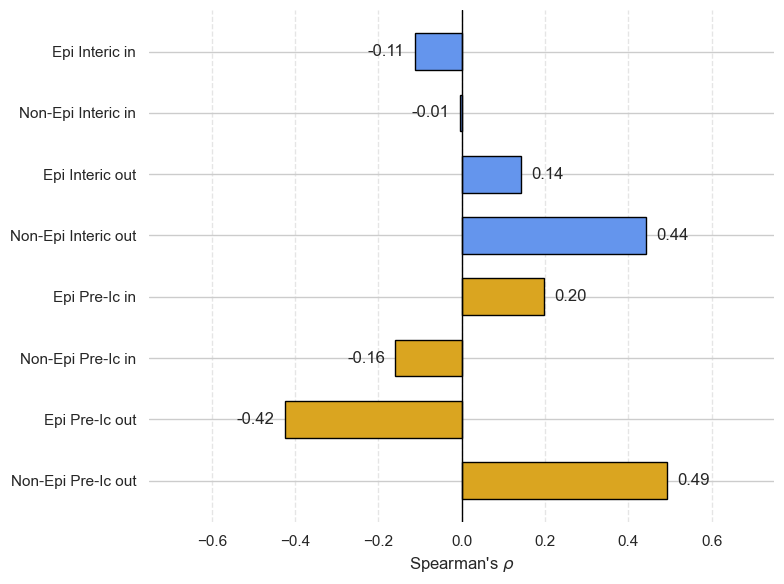

In [88]:
# Correlation values
correlations = [
    corr_fooof_inward_theta_epi_interictal,
    corr_fooof_inward_theta_nonepi_interictal,
    corr_fooof_outward_theta_epi_interictal,
    corr_fooof_outward_theta_nonepi_interictal,
    corr_fooof_inward_theta_epi,
    corr_fooof_inward_theta_nonepi,
    corr_fooof_outward_theta_epi,
    corr_fooof_outward_theta_nonepi
]

# Labels
labels = [
    "Epi Interic in",
    "Non-Epi Interic in",
    "Epi Interic out",
    "Non-Epi Interic out",
    "Epi Pre-Ic in",
    "Non-Epi Pre-Ic in",
    "Epi Pre-Ic out",
    "Non-Epi Pre-Ic out"
]

# Set Seaborn style for cleaner visuals
sns.set(style='whitegrid')

# Ensure values are floats
correlations = [float(c) for c in correlations]

# Colors: differentiate Resting vs Pre-Ictal
colors = ['goldenrod' if 'Pre-Ic' in lbl else 'cornflowerblue' for lbl in labels]

# Reverse order so first label appears at the top
correlations = correlations[::-1]
labels = labels[::-1]
colors = colors[::-1]

# Create plot
plt.figure(figsize=(8, 6))
bars = plt.barh(labels, correlations, color=colors, edgecolor='black', height=0.6)

# Axis labels
plt.xlabel(r"Spearman's $\rho$")

# Grid
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Axis limits and ticks
plt.xlim(-0.75, 0.75)
plt.xticks()
plt.yticks()

# Annotate values with fixed offset from bar edge
offset = 0.025  # Fixed distance from bar edge

for bar in bars:
    value = bar.get_width()
    xpos = value + offset if value >= 0 else value - offset
    ha = 'left' if value >= 0 else 'right'
    plt.text(xpos, bar.get_y() + bar.get_height() / 2,
             f"{value:.2f}", va='center', ha=ha)

# Optional: add subtle divider line between RS and Pre-Ic
#plt.axhline(3.5, color='black', linestyle='--', linewidth=1, alpha=0.3)

# Remove spines
sns.despine(left=True, bottom=True)
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)

plt.tight_layout()
plt.show()

#plt.savefig("G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\immagini finali\\supplementari\\Barplot correlations THETA band.png", dpi=700) 

In [136]:
from mne.stats import fdr_correction
dict_pvalues_theta = {
    'fooof_outward_theta_epi_preic': pval_fooof_outward_theta_epi,
    'fooof_outward_theta_nonepi_preic': pval_fooof_outward_theta_nonepi,
    'fooof_inward_theta_epi_preic': pval_fooof_inward_theta_epi,
    'fooof_inward_theta_nonepi_preic': pval_fooof_inward_theta_nonepi

}

rejected, pvals_corrected_theta = fdr_correction(list(dict_pvalues_theta.values()), alpha=0.05)
df = pd.DataFrame.from_dict(
    dict(zip(dict_pvalues_theta.keys(), pvals_corrected_theta)),
    orient='index',
    columns=['FDR Corrected p-value']
)
df = df.reset_index().rename(columns={'index': 'Correlation'})
print(df.to_markdown(index=False))

| Correlation                      |   FDR Corrected p-value |
|:---------------------------------|------------------------:|
| fooof_outward_theta_epi_preic    |               0.0547959 |
| fooof_outward_theta_nonepi_preic |               0.0361293 |
| fooof_inward_theta_epi_preic     |               0.42727   |
| fooof_inward_theta_nonepi_preic  |               0.42727   |


#### DELTA BAND BARPLOT

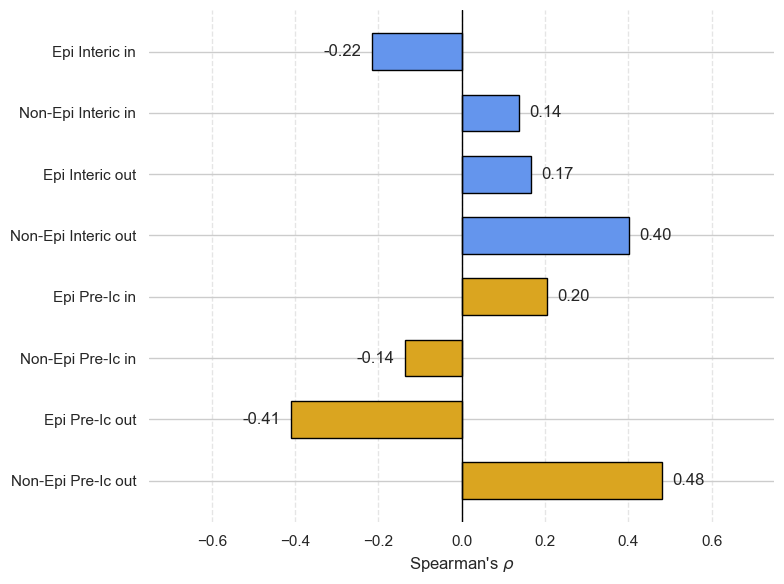

In [ ]:
# Correlation values
correlations = [
    corr_fooof_inward_delta_epi_interictal,
    corr_fooof_inward_delta_nonepi_interictal,
    corr_fooof_outward_delta_epi_interictal,
    corr_fooof_outward_delta_nonepi_interictal,
    corr_fooof_inward_delta_epi,
    corr_fooof_inward_delta_nonepi,
    corr_fooof_outward_delta_epi,
    corr_fooof_outward_delta_nonepi
]

# Labels
labels = [
    "Epi Interic in",
    "Non-Epi Interic in",
    "Epi Interic out",
    "Non-Epi Interic out",
    "Epi Pre-Ic in",
    "Non-Epi Pre-Ic in",
    "Epi Pre-Ic out",
    "Non-Epi Pre-Ic out"
]

# Set Seaborn style for cleaner visuals
sns.set(style='whitegrid')

# Ensure values are floats
correlations = [float(c) for c in correlations]

# Colors: differentiate Resting vs Pre-Ictal
colors = ['goldenrod' if 'Pre-Ic' in lbl else 'cornflowerblue' for lbl in labels]

# Reverse order so first label appears at the top
correlations = correlations[::-1]
labels = labels[::-1]
colors = colors[::-1]

# Create plot
plt.figure(figsize=(8, 6))
bars = plt.barh(labels, correlations, color=colors, edgecolor='black', height=0.6)

# Axis labels
plt.xlabel(r"Spearman's $\rho$")

# Grid
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Axis limits and ticks
plt.xlim(-0.75, 0.75)
plt.xticks()
plt.yticks()

# Annotate values with fixed offset from bar edge
offset = 0.025  # Fixed distance from bar edge

for bar in bars:
    value = bar.get_width()
    xpos = value + offset if value >= 0 else value - offset
    ha = 'left' if value >= 0 else 'right'
    plt.text(xpos, bar.get_y() + bar.get_height() / 2,
             f"{value:.2f}", va='center', ha=ha)

# Optional: add subtle divider line between RS and Pre-Ic
#plt.axhline(3.5, color='black', linestyle='--', linewidth=1, alpha=0.3)

# Remove spines
sns.despine(left=True, bottom=True)
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)

plt.tight_layout()
plt.show()

In [ ]:
from mne.stats import fdr_correction
dict_pvalues_delta = {
    'fooof_outward_delta_epi_preic': pval_fooof_outward_delta_epi,
    'fooof_outward_delta_nonepi_preic': pval_fooof_outward_delta_nonepi,
    'fooof_inward_delta_epi_preic': pval_fooof_inward_delta_epi,
    'fooof_inward_delta_nonepi_preic': pval_fooof_inward_delta_nonepi

}

rejected, pvals_corrected_delta = fdr_correction(list(dict_pvalues_delta.values()), alpha=0.05)
df = pd.DataFrame.from_dict(
    dict(zip(dict_pvalues_delta.keys(), pvals_corrected_delta)),
    orient='index',
    columns=['FDR Corrected p-value']
)
df = df.reset_index().rename(columns={'index': 'Correlation'})
print(df.to_markdown(index=False))


                        Correlation  FDR Corrected p-value
0     fooof_outward_delta_epi_preic               0.067677
1  fooof_outward_delta_nonepi_preic               0.044299
2      fooof_inward_delta_epi_preic               0.408230
3   fooof_inward_delta_nonepi_preic               0.494460
